In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm


from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Lambda, LSTM,  Bidirectional, Conv1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import RandomNormal, glorot_uniform

# Load Bitcoin price data

In [2]:
df = pd.read_csv("hourly_data_2024_08_02.csv", parse_dates =['time'])
df.set_index('time', inplace= True) # set `time` as index of dataframe
df = df[~df.index.duplicated(keep='first')] # drop duplicated indices
df = df[(df.index >= "2018-01-01") & (df.index <= "2024-07-30")] # To see why we drop old data, see Analysis_Statistcal_Models notebook

df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2018-01-01 00:00:00,13857.01,13598.91,13850.49,3936.05,5.414317e+07,13642.93,direct,NaN
2018-01-01 01:00:00,13690.14,13330.07,13642.93,3900.16,5.302141e+07,13352.04,direct,NaN
2018-01-01 02:00:00,13488.90,13318.52,13352.04,3028.41,4.079472e+07,13408.70,direct,NaN
2018-01-01 03:00:00,13647.63,13383.99,13408.70,3246.38,4.416929e+07,13458.77,direct,NaN
2018-01-01 04:00:00,13633.43,13364.42,13458.77,2931.72,3.982689e+07,13631.46,direct,NaN
...,...,...,...,...,...,...,...,...
2024-07-29 20:00:00,67391.82,67157.24,67300.34,694.72,4.673480e+07,67372.45,direct,NaN
2024-07-29 21:00:00,67504.08,67022.86,67372.45,695.05,4.673790e+07,67489.04,direct,NaN
2024-07-29 22:00:00,67545.84,67142.90,67489.04,566.95,3.818581e+07,67228.03,direct,NaN


# Calculate 8 hours weekly ROI 

In the Analysis_Statistical_Models notebook, we discussed the reasoning behind using the weekly ROI for every day of the week and every 4 and 8 hours. In this notebook, we train models using 8 hours data. In the following, we will create 8 hours data dataframe.

In [3]:
# This function calculates the weekly ROI based on the given day of the week and time.

def roi_df(dataframe, day, hour):
    df_out = pd.DataFrame()

    df_out["Day_Hour_Close"] = dataframe[(dataframe.index.hour == hour) &(dataframe.index.weekday == day)]["close"] 
    df_out["Next_Day_Hour_Close"] = df_out["Day_Hour_Close"].shift(-1)
    df_out.dropna(inplace = True)
    df_out["7_Day_ROI"]= (df_out['Next_Day_Hour_Close'] - df_out['Day_Hour_Close']) / df_out['Day_Hour_Close'] * 100
    df_out.drop(columns = ["Day_Hour_Close", "Next_Day_Hour_Close"], inplace = True)

    return df_out

In [4]:
df_8h = df[(df.index.hour == 4) | (df.index.hour == 12)  | (df.index.hour == 20)][["close"]]
df_8h

,close
time,
2018-01-01 04:00:00,13631.46
2018-01-01 12:00:00,13229.17
2018-01-01 20:00:00,13464.52
2018-01-02 04:00:00,13126.32
2018-01-02 12:00:00,13625.40
...,...
2024-07-28 12:00:00,68006.87
2024-07-28 20:00:00,68007.47
2024-07-29 04:00:00,69365.67


In [5]:
df_roi_8h = roi_df(df_8h, day=0, hour = 4)
df_roi12 = roi_df(df_8h, day =0, hour =12)
df_roi20 = roi_df(df_8h, day =0, hour =20)
df_roi_8h = pd.concat([df_roi_8h, df_roi12, df_roi20])

for d in range(1,8):
    df_roi_new4= roi_df(df_8h, day=d, hour = 4)
    df_roi_new12= roi_df(df_8h, day=d, hour = 12)
    df_roi_new20= roi_df(df_8h, day=d, hour = 20)

    df_roi_8h = pd.concat([df_roi_8h, df_roi_new4, df_roi_new12, df_roi_new20])
    


df_roi_8h = df_roi_8h.sort_index()
df_roi_8h.index.name = "time"
df_roi_8h

C:\Users\solmaz\AppData\Local\Temp\ipykernel_10552\1653126019.py:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_roi_8h = pd.concat([df_roi_8h, df_roi_new4, df_roi_new12, df_roi_new20])


,7_Day_ROI
time,
2018-01-01 04:00:00,15.253098
2018-01-01 12:00:00,16.635586
2018-01-01 20:00:00,11.286552
2018-01-02 04:00:00,17.149285
2018-01-02 12:00:00,8.509108
...,...
2024-07-21 12:00:00,1.576866
2024-07-21 20:00:00,0.391825
2024-07-22 04:00:00,2.102873


# Naive Model

Before we proceed to advanced methods, let's look at the prediction from a naive model, which assigns the value of the last time slot to the current time slot as the prediction. This will serve as our baseline accuracy.

In [6]:
split = pd.to_datetime("2023-12-31 20:00:00")
train = df_roi_8h.loc[: split]
test  = df_roi_8h.loc[split + timedelta(hours=8):]

print("Number of data in train:", len(train))
print("Number of data in train:", len(test))


df_naive_8h  = df_roi_8h["7_Day_ROI"].shift(-1)
prediction_naive = df_naive_8h[split + timedelta(hours=8):]
prediction_naive[-1] = prediction_naive[-2]
prediction_naive

Number of data in train: 6573
Number of data in train: 612


C:\Users\solmaz\AppData\Local\Temp\ipykernel_10552\1692100432.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediction_naive[-1] = prediction_naive[-2]
C:\Users\solmaz\AppData\Local\Temp\ipykernel_10552\1692100432.py:11: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  prediction_naive[-1] = prediction_naive[-2]


time
2024-01-01 04:00:00    5.860147
2024-01-01 12:00:00    7.128274
2024-01-01 20:00:00    3.572698
2024-01-02 04:00:00    1.921754
2024-01-02 12:00:00    4.135655
                         ...   
2024-07-21 12:00:00    0.391825
2024-07-21 20:00:00    2.102873
2024-07-22 04:00:00    3.088608
2024-07-22 12:00:00   -1.128811
2024-07-22 20:00:00   -1.128811
Name: 7_Day_ROI, Length: 612, dtype: float64

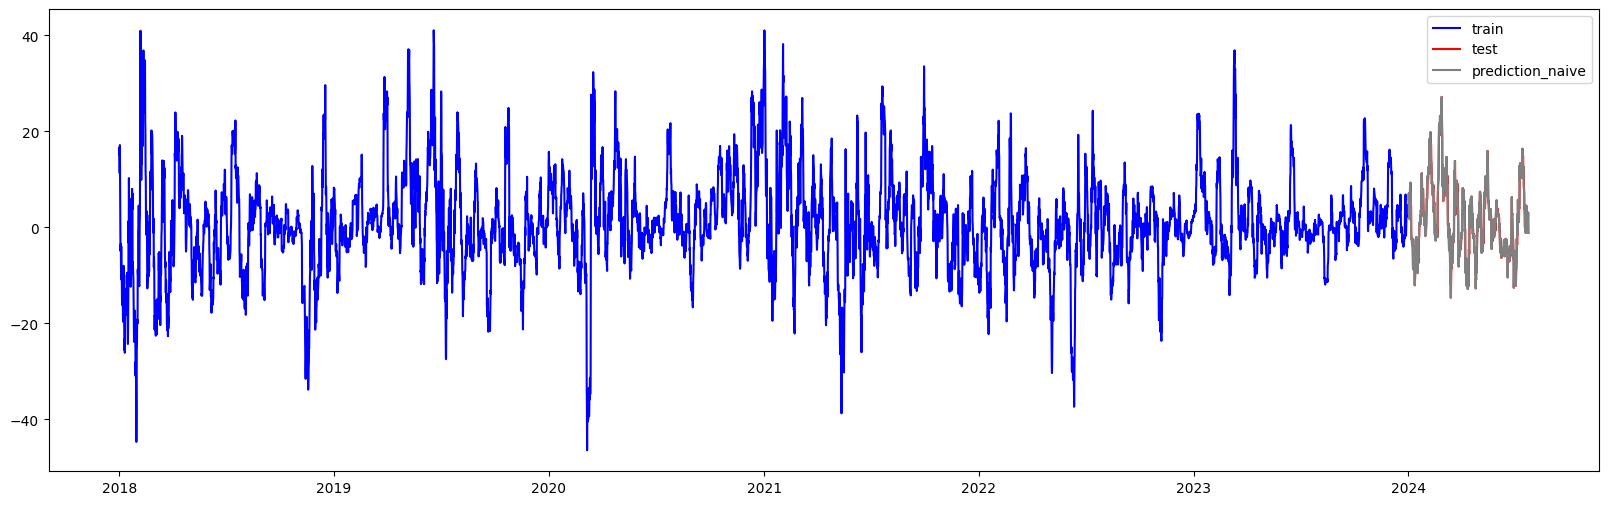

In [7]:
plt.figure(figsize = (20,6))
plt.plot(train, color = "blue", label = "train")
plt.plot(test, color = "red", label = "test")
plt.plot(prediction_naive, color = "gray", label = "prediction_naive")
plt.legend()

In [8]:
mae = mean_absolute_error(test, prediction_naive)
print("Mean absolute Error: ", mae)

mse = mean_squared_error(test, prediction_naive)
print("Mean Square Error: ", mse)

Mean absolute Error:  1.6485589430303649
Mean Square Error:  5.211349935042911


# Data preprocessing

We are going to use sequential models (like RNN, LSTM) and need to prepare the data in a way that it can be fed into these models. Sequential models require the input to be structured as sequences with a length equals to the given `window_size`. The following chunk of code defines a `preprocessing` function that transforms the input data into sequences and prepares it for training:


1. Convert data to a TensorFlow dataset: The input data is converted into a TensorFlow dataset format which prepares the data for further transformations.

2. Create sliding windows: Sliding windows are created over the dataset, with each window containing a specified number of elements `window_size`. The window moves by a specified number of elements `shift`. We set `remainder =True` to exclude the windows wich have less elements

3. Convert windows into batches: Since each window has dataset type, we have to change their type to tensor using `flat_map` mathod.

4. Split windows into features and labels: The data in each window is split into two parts: features and labels. The features are all elements except the last one, while the label is the last element. This prepares the input-output pairs needed for training the model.

5. Shuffle the dataset: The dataset is shuffled to avoid model overfitting and ensure better training performance. Shuffling introduces randomness into the order of the data, which helps the model generalize better.

6. Batch and prefetch the data: The dataset is divided into batches of a specified size, which will be fed into the model during training. Prefetching is used to optimize performance by loading data in advance, reducing waiting times during model execution.


In [9]:
def preprocessing(data, window_size, batch_size, shuffle_buffer_size, shift=1 ):
    
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(size=window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    feature_label = dataset.map(lambda window: (window[:-1], window[-1]))
    feature_label = feature_label.shuffle(buffer_size=shuffle_buffer_size)
    feature_label = feature_label.batch(batch_size).prefetch(1)
    return feature_label

We will also use the following function whenever we want to check the performance of the model and visualize the model's results. The following `make_prediction` function helps us generate forecasts using a trained model and compare them with actual data.

In [10]:
def make_prediction(dataframe, model, time_feature, feature_name , window_size, split_index, verbose, test = True):
    '''
    dataframe must be the Pandas series or numpy array of the whole(train and test) variable
    split_index = len(train)
    '''
    if isinstance(dataframe.index, pd.DatetimeIndex):
        dataframe.reset_index(inplace=True)
    
    forecast = []
    if test:
        start_index = split_index-window_size+1
        no_windows = len(dataframe)-start_index-window_size+1
        time = dataframe[time_feature][split_index: ]
        #print(start_index)
        #print(no_windows)
    else:
        start_index = 0
        no_windows = split_index-window_size+1
        time = dataframe[time_feature][window_size-1:split_index]

    if len(time) == no_windows:
        for i in range(start_index, start_index+no_windows):
            forecast.append(model.predict(dataframe[feature_name][i:window_size-1+i].values[np.newaxis], verbose = verbose))

    else:
        raise Exception("Not equal number of time stamps and number of windows")
    

    return time, np.array(forecast).squeeze()


In the following code block we define `learning_curve` function that will help us visualize the learning curve during model training. It provides insights into how well the model is learning and when to stop training. It helps us assess whether the model is improving or if it is starting to overfit.It also helps us to determine if the model has reached a point that doesn't improve or when the validation performance starts to degrade. Let's discuss the parameters of the function: 

1. `history`: The training history object returned by the Keras model after training, containing the recorded metrics at each epoch.

2. `metrics`: A list of metrics you want to plot (e.g., ["loss", "accuracy"]).

3. `zoom_in_epoch`: The starting epoch from which you want to zoom in and visualize the learning curves (useful for focusing on later stages of training).

4. `metrics_max`: The maximum value for each of the metrics on the y-axis, which helps in controlling the scale of the plots.

5. `val`: A boolean indicating whether to include validation metrics in the plots (if validation data was used during training).

In [11]:
def learning_curve(history, metrics , zoom_in_epoch, metrics_max, val= True):
    epochs = len(history.history[metrics[0]])
    metric0_values_train = history.history[metrics[0]][zoom_in_epoch:]
    metric1_values_train = history.history[metrics[1]][zoom_in_epoch:]
    if val:
        metric0_values_val = history.history["val_"+metrics[0]][zoom_in_epoch:]
        metric1_values_val = history.history["val_"+metrics[1]][zoom_in_epoch:]
    
    epoch_range = range(zoom_in_epoch, zoom_in_epoch+ len(metric1_values_train))

    fig, ax = plt.subplots(1,2, figsize= (15,5))
    ax[0].set_title(f"{metrics[0]} learning curve")
    ax[0].plot(epoch_range, metric0_values_train, label = f"Training", color = "b")
    if val:
        ax[0].plot(epoch_range, metric0_values_val, label = f"Validation", color = "r")
    ax[0].axis([zoom_in_epoch, epochs, 0, metrics_max[0] ])
    ax[0].legend()

    ax[1].set_title(f"{metrics[1]} learning curve")
    ax[1].plot(epoch_range, metric1_values_train, label = f"Training", color = "b")
    if val:
        ax[1].plot(epoch_range, metric1_values_val, label = f"Validation", color = "r")
    ax[1].axis([zoom_in_epoch, epochs, 0, metrics_max[1] ])
    ax[1].legend()

# Model Training

In [12]:
# Train Test split
split = pd.to_datetime("2023-12-31 20:00:00")
split_index = df_roi_8h.index.get_loc(split)
train = df_roi_8h.loc[: split]
test  = df_roi_8h.loc[split + timedelta(hours = 8):]
split_index = len(train)
exact_test  = test[(test.index.hour == 20) &(test.index.weekday == 0)]

In [13]:
## Set values for the training variables
window_size = 9
batch_size = 256


In [14]:
## Create train and test sequetial data

feature_label_train = preprocessing(train["7_Day_ROI"], window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

feature_label_test = preprocessing(test["7_Day_ROI"].values,  window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

To provide more insight into the output of `preprocess` function, let's print elements of a single batch is `feature_label_train`:

In [15]:
for windows in feature_label_train.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  x,y = windows
  print("x = ", x.numpy())
  print("Shape of x:", x.shape)
  print("y = ", y.numpy())
  print("Shape of y:", y.shape)
  print()

data type: <class 'tuple'>
number of elements in the tuple: 2
x =  [[-15.74619618 -14.78458108 -14.1120939  ... -14.606003   -19.57022279
  -18.42718553]
 [ -3.48248308 -10.21500831 -12.35531407 ...  -3.27805595   6.02372621
   -0.81781711]
 [ 13.0529457   13.69043545  14.67088008 ...  14.283626    14.35964313
   15.43334628]
 ...
 [  8.27830775   7.70557807   8.12564722 ...   4.69097629   2.59783674
    3.7330619 ]
 [  0.761544    -1.69823336  -3.1102569  ...  -3.41189019  -2.26665677
   -7.29765391]
 [  5.65526957   8.18554097   7.9240222  ...  18.67966967  20.42338751
   17.28632604]]
Shape of x: (256, 8)
y =  [-6.05227461e+00 -1.47952649e+00  1.69820557e+01 -3.75474110e+00
 -3.51483578e+00 -4.79419599e+00 -6.33043738e+00  1.98247874e+01
 -2.38026581e+00 -1.84114354e+01  9.40574262e+00 -2.97012865e+00
 -1.68649143e+00 -1.13607920e+01 -1.46790693e-01 -5.91431875e+00
 -3.11135891e+00  1.11559233e+01  2.53288582e+00 -3.70880908e+00
  2.80967035e+00  7.16938400e+00 -3.87439750e+00 -1.78

## One layer network: Linear Regression

In [19]:
# Build the single layer neural network with one unit and identity activation function
l0 = Dense(1, input_shape=[window_size-1])
lr = Sequential([l0])

lr.summary()

c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
lr.compile(loss="mae", metrics = ['mae'], optimizer=SGD(learning_rate=1e-5, momentum=0.9))
history = lr.fit(feature_label_train, epochs=250, validation_data= feature_label_test)

Epoch 1/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.7315 - mae: 8.7315 - val_loss: 7.1925 - val_mae: 7.1925
Epoch 2/250


c:\Users\solmaz\anaconda3\envs\TR\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5579 - mae: 8.5579 - val_loss: 6.8382 - val_mae: 6.8382
Epoch 3/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0607 - mae: 8.0607 - val_loss: 6.5151 - val_mae: 6.5151
Epoch 4/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5101 - mae: 7.5101 - val_loss: 6.2327 - val_mae: 6.2327
Epoch 5/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4743 - mae: 7.4743 - val_loss: 5.9898 - val_mae: 5.9898
Epoch 6/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1740 - mae: 7.1740 - val_loss: 5.7825 - val_mae: 5.7825
Epoch 7/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7760 - mae: 6.7760 - val_loss: 5.6074 - val_mae: 5.6074
Epoch 8/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7317 - mae: 6.7317 - val_loss: 5.4619 - val_mae: 5.4619
Epoch 9/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4816 - mae: 6.4816 - val_loss: 5.3393 - val_mae: 5.3393
Epoch 10/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3113 - mae: 6.

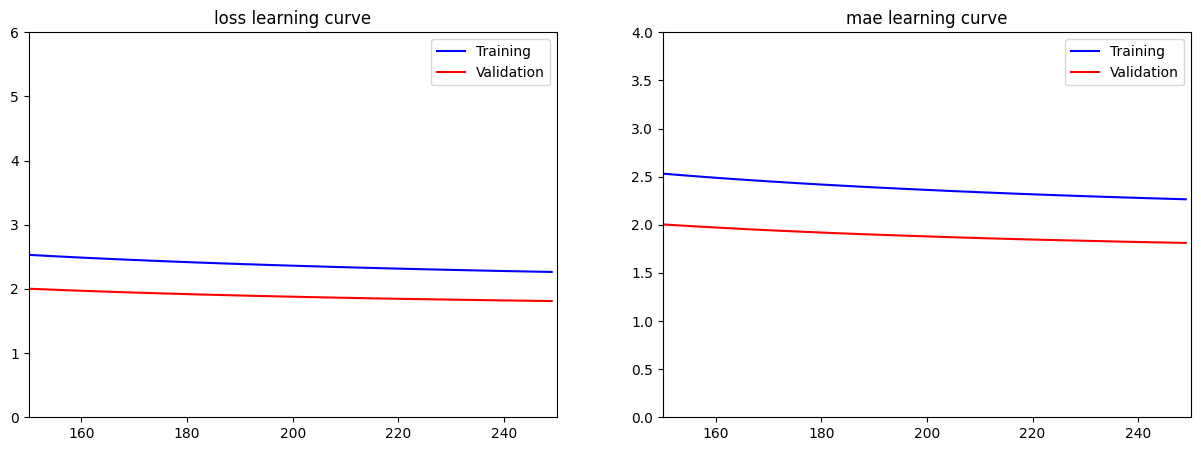

In [23]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch= 150, metrics_max = [6, 4], val= True)

In [24]:
time_train, forecast_train_lr = make_prediction(df_roi_8h, model = lr, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = False)
time_test, forecast_test_lr = make_prediction(df_roi_8h, model = lr, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True)

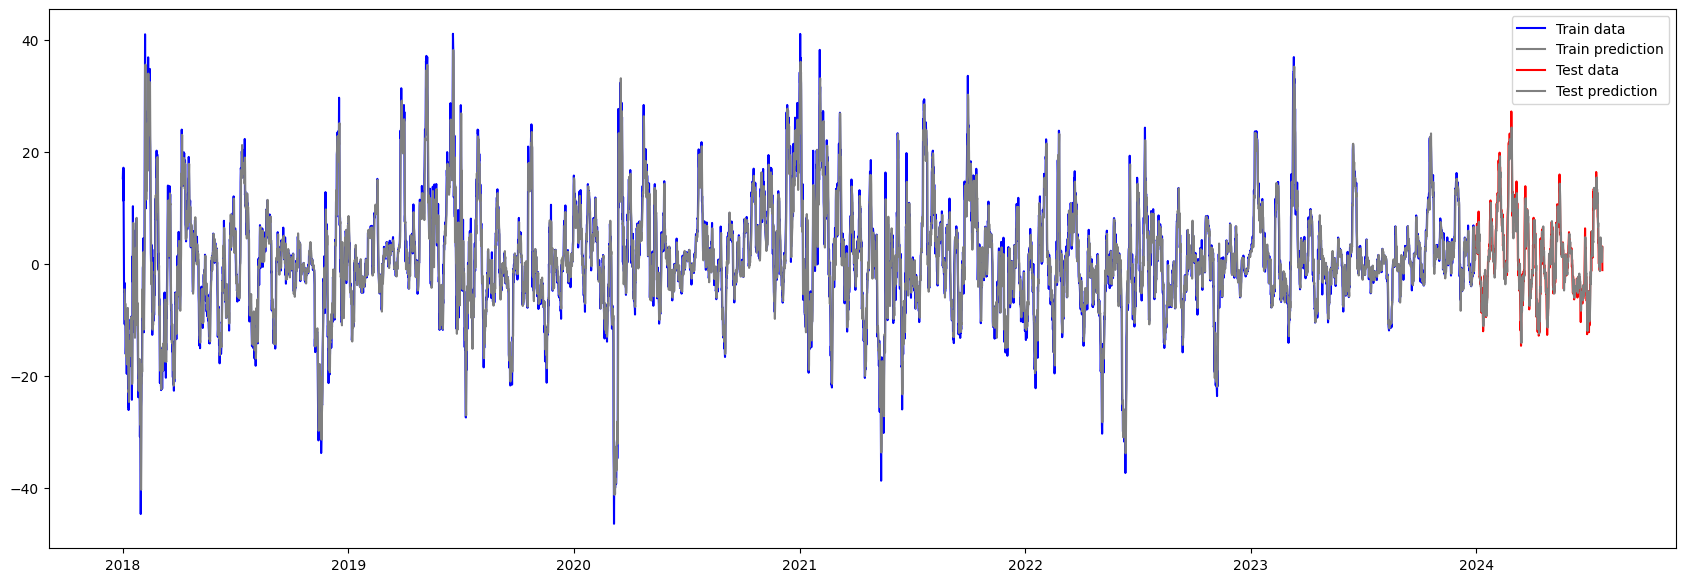

In [25]:
plt.figure(figsize = (21,7))
plt.plot(train, color = 'blue', label = "Train data")
plt.plot(time_train, forecast_train_lr, color = "gray", label = "Train prediction")
plt.plot(test, color = 'red', label = "Test data")
plt.plot(time_test, forecast_test_lr, color = "gray", label = "Test prediction")

plt.legend()

In [27]:
mae = mean_absolute_error(test.values, forecast_test_lr)
print("Mean absolute Error: ", mae)

mse = mean_squared_error(test.values, forecast_test_lr)
print("Mean Square Error: ", mse)

Mean absolute Error:  1.817261739690312
Mean Square Error:  5.97741031814908


## Three layers NNs

In [19]:
model_3dnn = Sequential()
model_3dnn.add(Dense(20, activation = 'relu', input_shape = [window_size-1]))
model_3dnn.add(Dense(20, activation = 'relu'))
model_3dnn.add(Dense(1))


model_3dnn.compile(loss = 'mse', metrics = ["mae"], optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_3dnn.fit(feature_label_train, epochs=120, validation_data= feature_label_test)

Epoch 1/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 112.7016 - mae: 7.2762 - val_loss: 17.9130 - val_mae: 3.2708
Epoch 2/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.5214 - mae: 4.0480 - val_loss: 11.6179 - val_mae: 2.5750
Epoch 3/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.0269 - mae: 3.1555 - val_loss: 9.6246 - val_mae: 2.3456
Epoch 4/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8297 - mae: 2.8868 - val_loss: 8.5550 - val_mae: 2.2068
Epoch 5/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.6860 - mae: 2.7858 - val_loss: 7.9038 - val_mae: 2.1265
Epoch 6/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.7243 - mae: 2.6518 - val_loss: 7.5368 - val_mae: 2.0790
Epoch 7/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.8361 - mae: 2.5955 - val_loss: 7.2936 - val_mae: 2.0452
Epoch 8/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.2945 - mae: 2.5776 - val_loss: 7.1136 - val_mae: 2.0202
Epoch 9/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

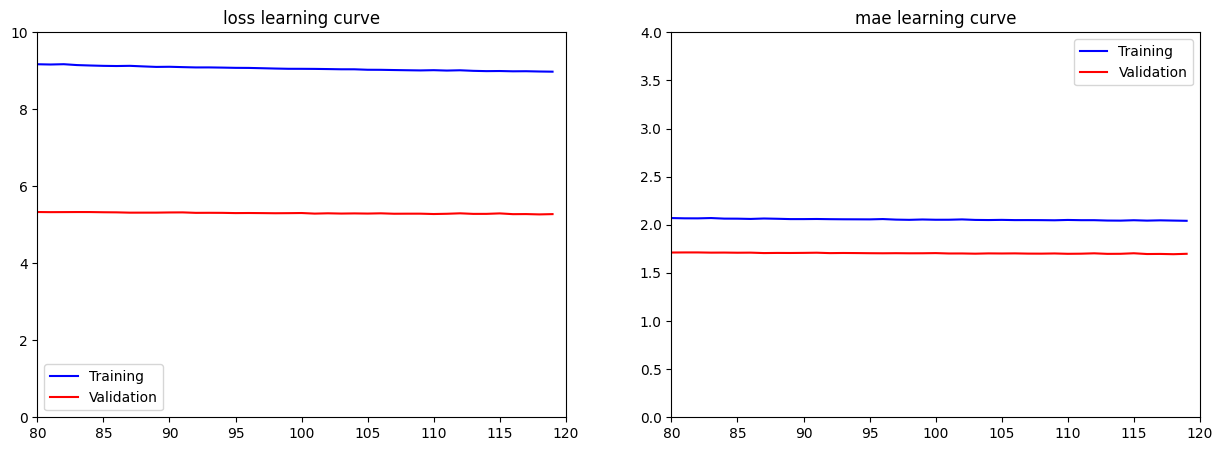

In [22]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch= 80, metrics_max = [10, 4], val= True)

In [23]:
time_train, forecast_train_3dnn = make_prediction(df_roi_8h, model = model_3dnn, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = False)
time_test, forecast_test_3dnn = make_prediction(df_roi_8h, model = model_3dnn, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True)

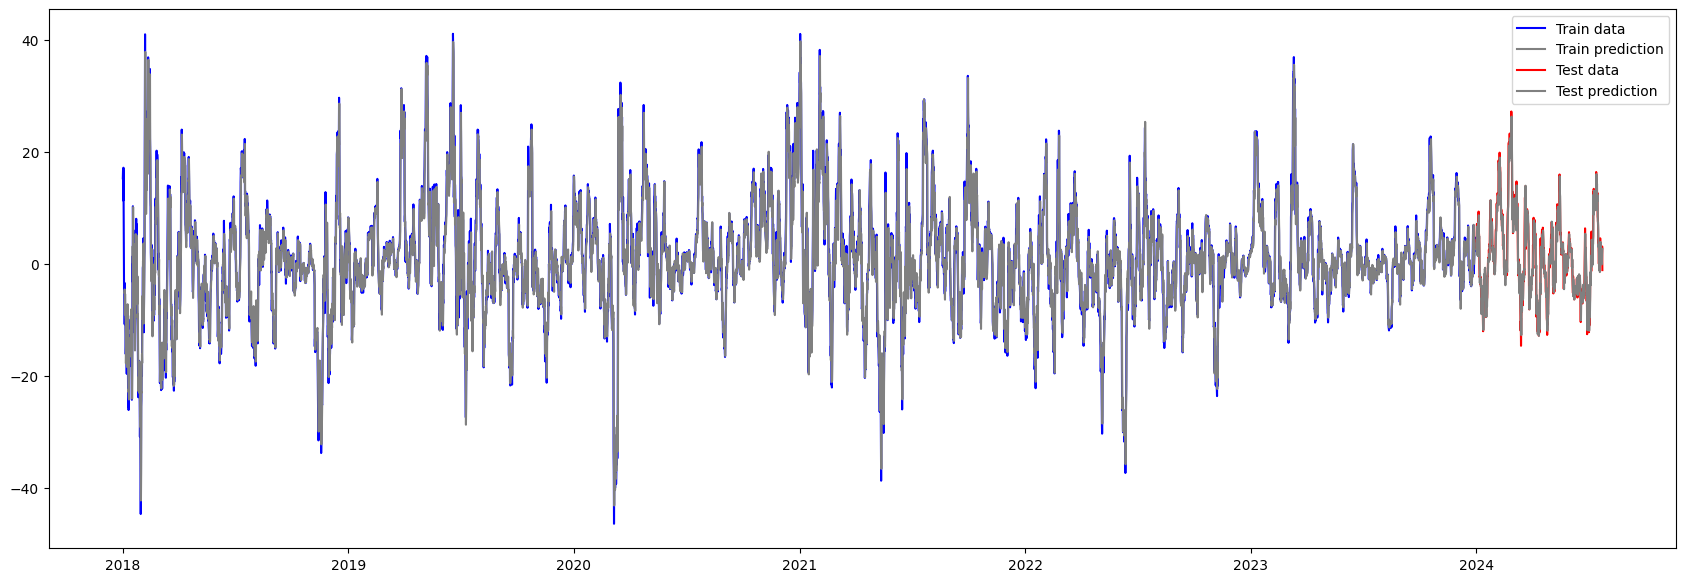

In [24]:
plt.figure(figsize = (21,7))
plt.plot(train, color = 'blue', label = "Train data")
plt.plot(time_train, forecast_train_3dnn, color = "gray", label = "Train prediction")
plt.plot(test, color = 'red', label = "Test data")
plt.plot(time_test, forecast_test_3dnn, color = "gray", label = "Test prediction")

plt.legend()

In [25]:
mae = mean_absolute_error(test.values, forecast_test_3dnn)
print("Mean absolute Error: ", mae)

mse = mean_squared_error(test.values, forecast_test_3dnn)
print("Mean Square Error: ", mse)

Mean absolute Error:  1.7053610825642505
Mean Square Error:  5.282614795043367


It seems the performance of the 3-layer neural network is better than that of the 1-layer model on this data. Let's proceed with more advanced models.

## SimpleRNN

### Try 1

In [48]:
# Build the Model
model_rnn = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size-1]), # Add an extra dimension to the input to make it compatible with the RNN layer
  SimpleRNN(50),
  Dense(1, activation = 'relu'),
  Lambda(lambda x: x * 10)   # Scale the output by a factor of 10 to match the data range

])

model_rnn.compile(loss = "mse", metrics = ["mae"],optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_rnn.fit(feature_label_train, epochs = 80, validation_data= feature_label_test )

Epoch 1/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 152.1229 - mae: 8.8795 - val_loss: 21.3811 - val_mae: 3.6245
Epoch 2/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.0769 - mae: 4.9166 - val_loss: 21.3925 - val_mae: 3.7222
Epoch 3/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.9000 - mae: 4.6365 - val_loss: 19.9000 - val_mae: 3.4975
Epoch 4/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.8495 - mae: 4.4738 - val_loss: 19.3986 - val_mae: 3.4046
Epoch 5/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.1858 - mae: 4.3930 - val_loss: 19.0870 - val_mae: 3.3404
Epoch 6/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.7191 - mae: 4.4063 - val_loss: 18.9612 - val_mae: 3.3117
Epoch 7/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.0996 - mae: 4.4031 - val_loss: 18.8735 - val_mae: 3.2935
Epoch 8/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.4300 - mae: 4.2598 - val_loss: 18.8029 - val_mae: 3.2800
Epoch 9/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - los

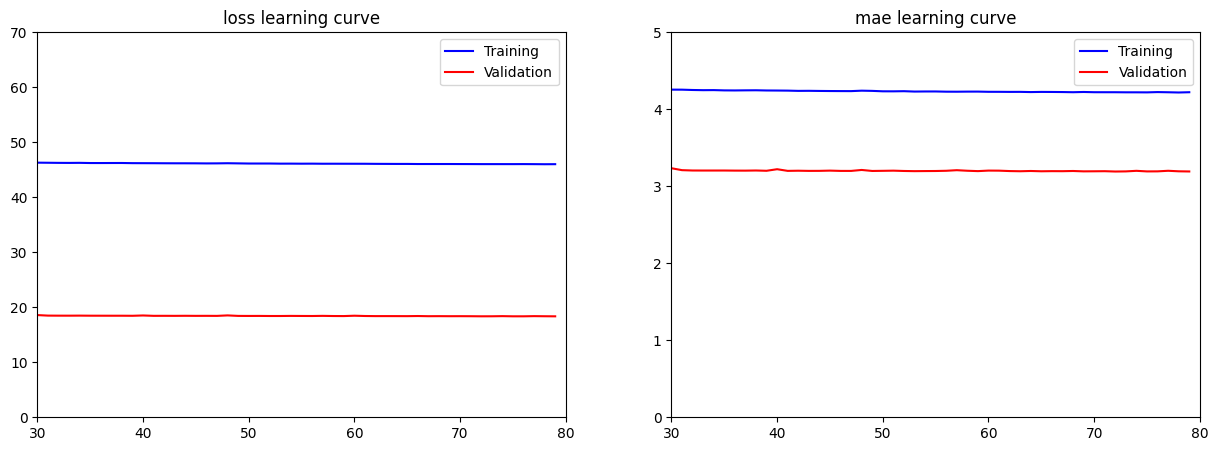

In [49]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch=30, metrics_max = [70, 5], val= True)

In [52]:
#time_train, forecast_train_rnn = make_prediction(df_roi_8h, model = model_3dnn, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = False)
time_test, forecast_test_rnn = make_prediction(df_roi_8h, model = model_rnn, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True)

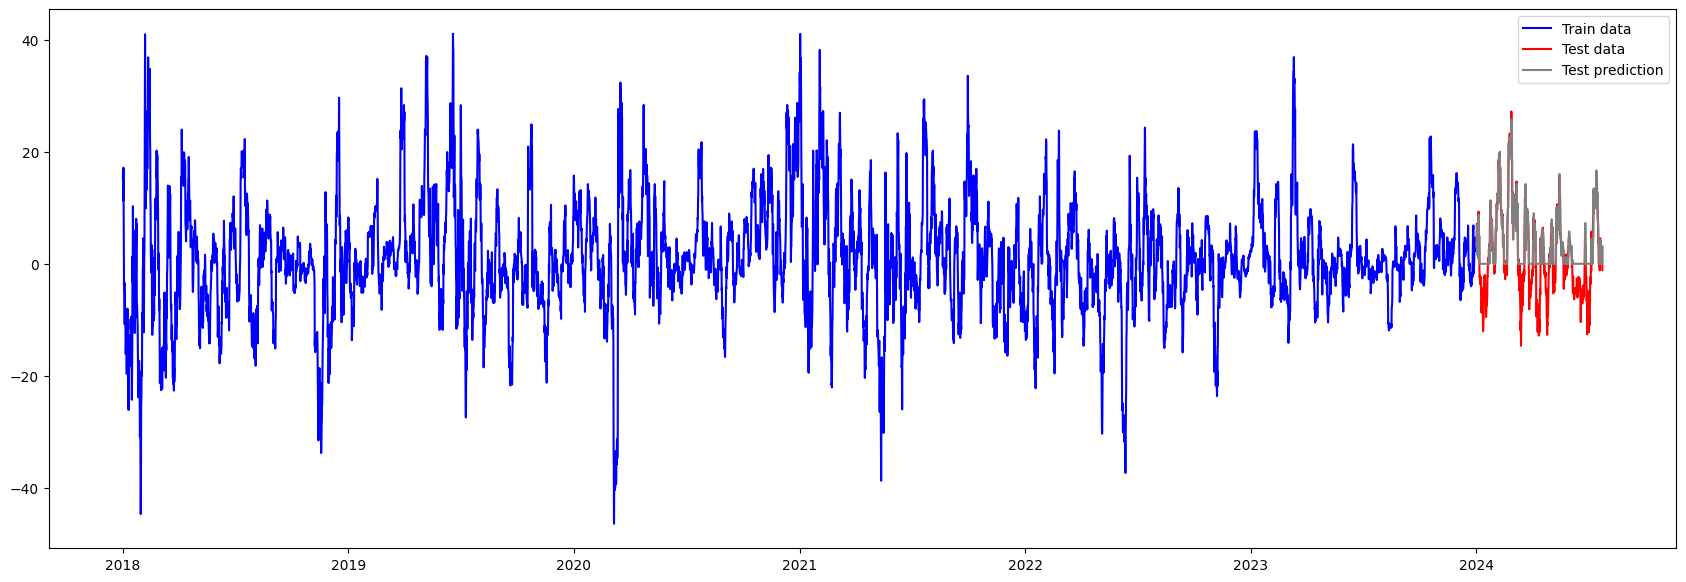

In [53]:
plt.figure(figsize = (21,7))
plt.plot(train, color = 'blue', label = "Train data")
#plt.plot(time_train, forecast_train_rnn, color = "gray", label = "Train prediction")
plt.plot(test, color = 'red', label = "Test data")
plt.plot(time_test, forecast_test_rnn, color = "gray", label = "Test prediction")

plt.legend()

In [54]:
mae = mean_absolute_error(test.values, forecast_test_rnn)
print("Mean absolute Error: ", mae)

mse = mean_squared_error(test.values, forecast_test_rnn)
print("Mean Square Error: ", mse)

Mean absolute Error:  3.180576759129346
Mean Square Error:  18.194823848613552


The performance of this RNN network is not as good as the 3-layer neural network. Let's try a different architecture:

### Try 2

In [20]:
# Build the Model
model_rnn = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size-1]), # Add an extra dimension to the input to make it compatible with the RNN layer
  SimpleRNN(50, return_sequences= True),
  SimpleRNN(20),
  Dense(1, activation = 'relu'),
  Lambda(lambda x: x * 10)   # Scale the output by a factor of 10 to match the data range

])

model_rnn.compile(loss = "mse", metrics = ["mae"],optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_rnn.fit(feature_label_train, epochs = 80, validation_data= feature_label_test )

Epoch 1/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 62.9072 - mae: 5.5472 - val_loss: 24.4991 - val_mae: 3.9941
Epoch 2/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.2002 - mae: 5.1380 - val_loss: 22.0943 - val_mae: 3.7204
Epoch 3/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53.0538 - mae: 4.8687 - val_loss: 20.5663 - val_mae: 3.4973
Epoch 4/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.4119 - mae: 4.5828 - val_loss: 20.0323 - val_mae: 3.4545
Epoch 5/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49.3045 - mae: 4.5689 - val_loss: 19.5525 - val_mae: 3.3843
Epoch 6/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.1274 - mae: 4.5716 - val_loss: 19.2200 - val_mae: 3.3284
Epoch 7/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.6411 - mae: 4.5293 - val_loss: 18.9888 - val_mae: 3.2901
Epoch 8/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.3825 - mae: 4.5159 - val_loss: 18.8071 - val_mae: 3.2514
Epoch 9/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - los

Adding an additional RNN layer did not improve the model's performance.

### Try 3

In [23]:
# Build the Model
model_rnn = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size-1]), # Add an extra dimension to the input to make it compatible with the RNN layer
  SimpleRNN(50),
  Dense(50, activation = 'relu'),
  #Dense(40, activation = 'relu'),
  Dense(1, activation = 'relu'),
  Lambda(lambda x: x * 10)   # Scale the output by a factor of 10 to match the data range

])

model_rnn.compile(loss = "mse", metrics = ["mae"],optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_rnn.fit(feature_label_train, epochs = 80, validation_data= feature_label_test )

Epoch 1/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 78.5427 - mae: 6.1838 - val_loss: 19.9727 - val_mae: 3.4666
Epoch 2/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.7328 - mae: 4.6603 - val_loss: 20.1791 - val_mae: 3.5419
Epoch 3/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.3400 - mae: 4.4841 - val_loss: 19.5141 - val_mae: 3.4363
Epoch 4/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.6503 - mae: 4.4340 - val_loss: 19.0810 - val_mae: 3.3472
Epoch 5/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45.3202 - mae: 4.2876 - val_loss: 19.0051 - val_mae: 3.3287
Epoch 6/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.7448 - mae: 4.3940 - val_loss: 18.7525 - val_mae: 3.2803
Epoch 7/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.9327 - mae: 4.4116 - val_loss: 18.6991 - val_mae: 3.2685
Epoch 8/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.0068 - mae: 4.3054 - val_loss: 18.6119 - val_mae: 3.2498
Epoch 9/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

## LSTM

### Try 1

In [33]:
## Clears the current TensorFlow Keras session to free up resources and reset the state of the computational graph
tf.keras.backend.clear_session()


# Build the Model
model_lstm = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size-1]), # Add an extra dimension to the input to make it compatible with the RNN layer
  LSTM(50),
  Dense(1, activation = 'relu'),
  Lambda(lambda x: x * 10)   # Scale the output by a factor of 10 to match the data range
])

model_lstm.compile(loss = "mse", metrics = ["mae"],optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_lstm.fit(feature_label_train, epochs = 80, validation_data= feature_label_test )

Epoch 1/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 91.7140 - mae: 6.6996 - val_loss: 29.8898 - val_mae: 4.6036
Epoch 2/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 59.1757 - mae: 5.5743 - val_loss: 20.3215 - val_mae: 3.4540
Epoch 3/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48.3071 - mae: 4.5087 - val_loss: 19.4834 - val_mae: 3.3547
Epoch 4/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48.7778 - mae: 4.4208 - val_loss: 19.2486 - val_mae: 3.3178
Epoch 5/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48.1831 - mae: 4.4263 - val_loss: 18.8699 - val_mae: 3.2551
Epoch 6/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 50.1494 - mae: 4.4862 - val_loss: 18.7164 - val_mae: 3.2294
Epoch 7/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 46.4087 - mae: 4.3056 - val_loss: 18.6291 - val_mae: 3.2161
Epoch 8/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 48.0458 - mae: 4.3320 - val_loss: 18.6020 - val_mae: 3.2125
Epoch 9/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - los

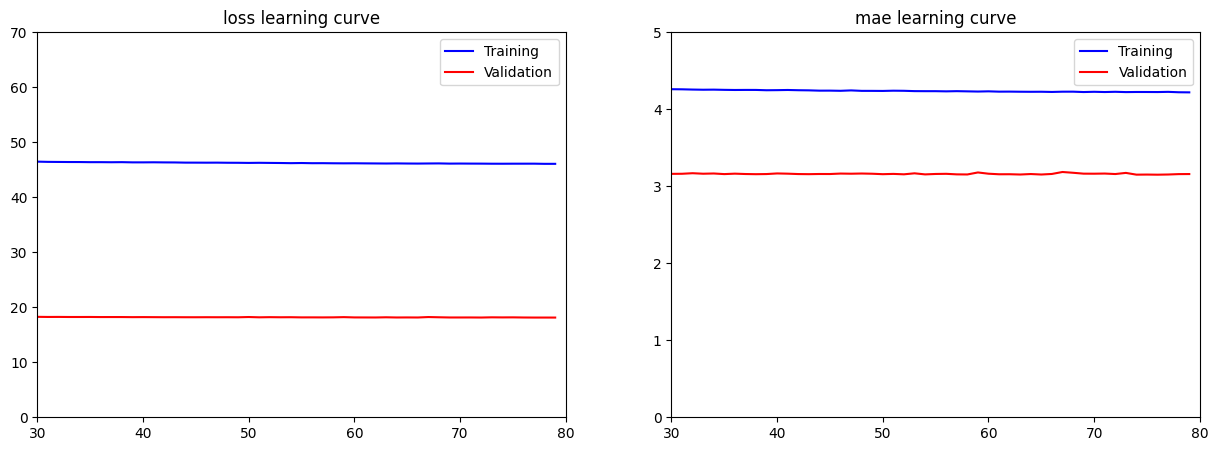

In [34]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch=30, metrics_max = [70, 5], val= True)

In [28]:
time_test, forecast_test_lstm = make_prediction(df_roi_8h, model = model_lstm, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True)

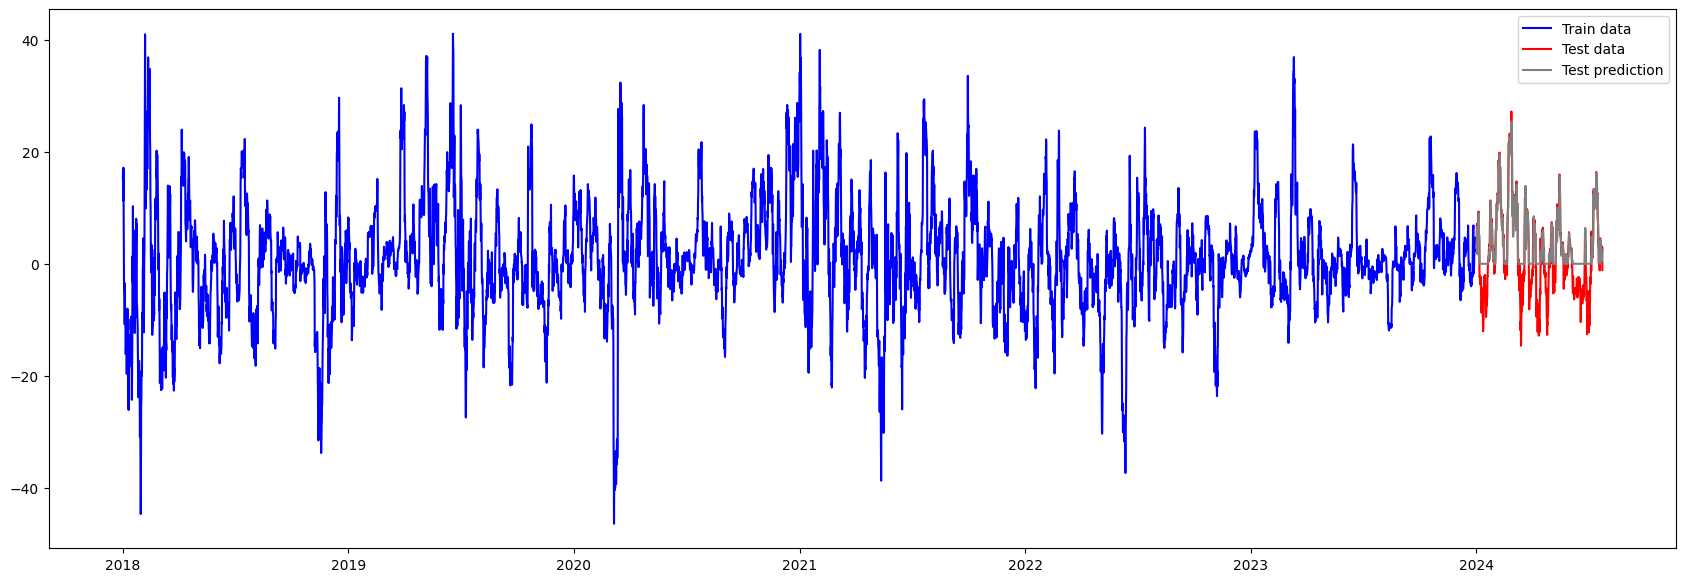

In [29]:
plt.figure(figsize = (21,7))
plt.plot(train, color = 'blue', label = "Train data")
#plt.plot(time_train, forecast_train_lstm, color = "gray", label = "Train prediction")
plt.plot(test, color = 'red', label = "Test data")
plt.plot(time_test, forecast_test_lstm, color = "gray", label = "Test prediction")

plt.legend()

### Try 2

In [40]:
## Clears the current TensorFlow Keras session to free up resources and reset the state of the computational graph
tf.keras.backend.clear_session()


# Build the Model
model_lstm = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size-1]), # Add an extra dimension to the input to make it compatible with the RNN layer
  LSTM(50),
  Dense(40, activation = 'relu'),
  Dense(1, activation = 'relu'),
  Lambda(lambda x: x * 10)   # Scale the output by a factor of 10 to match the data range
])

model_lstm.compile(loss = "mse", metrics = ["mae"], optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_lstm.fit(feature_label_train, epochs = 80, validation_data= feature_label_test )

Epoch 1/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 68.7773 - mae: 5.8156 - val_loss: 24.7566 - val_mae: 4.1204


c:\Users\solmaz\anaconda3\envs\TR\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 2/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 55.4814 - mae: 4.9426 - val_loss: 19.7989 - val_mae: 3.4158
Epoch 3/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.7410 - mae: 4.5770 - val_loss: 19.0185 - val_mae: 3.2966
Epoch 4/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48.5280 - mae: 4.4037 - val_loss: 18.8615 - val_mae: 3.2721
Epoch 5/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46.1732 - mae: 4.3544 - val_loss: 18.6058 - val_mae: 3.2253
Epoch 6/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 49.4739 - mae: 4.3970 - val_loss: 18.5850 - val_mae: 3.2239
Epoch 7/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47.6511 - mae: 4.3483 - val_loss: 18.4695 - val_mae: 3.2033
Epoch 8/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46.5883 - mae: 4.2938 - val_loss: 18.3722 - val_mae: 3.1855
Epoch 9/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46.2882 - mae: 4.2831 - val_loss: 18.4269 - val_mae: 3.1967
Epoch 10/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - los

## Bidirectional LSTM

In [42]:
## Clears the current TensorFlow Keras session to free up resources and reset the state of the computational graph
tf.keras.backend.clear_session()


# Build the Model
model_lstm = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size-1]), # Add an extra dimension to the input to make it compatible with the RNN layer
  Bidirectional(LSTM(50)),
  Dense(1, activation = 'relu'),
  Lambda(lambda x: x * 10)   # Scale the output by a factor of 10 to match the data range
])

model_lstm.compile(loss = "mse", metrics = ["mae"],optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_lstm.fit(feature_label_train, epochs = 80, validation_data= feature_label_test )

Epoch 1/80


c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     24/Unknown 2s 4ms/step - loss: 67.3162 - mae: 5.7220

c:\Users\solmaz\anaconda3\envs\TR\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 66.5772 - mae: 5.6848 - val_loss: 23.6608 - val_mae: 3.9312
Epoch 2/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 51.9945 - mae: 4.8076 - val_loss: 20.1605 - val_mae: 3.4683
Epoch 3/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52.4374 - mae: 4.7059 - val_loss: 19.6607 - val_mae: 3.4104
Epoch 4/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 49.0985 - mae: 4.5423 - val_loss: 19.3528 - val_mae: 3.3646
Epoch 5/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47.1516 - mae: 4.4332 - val_loss: 19.1060 - val_mae: 3.3284
Epoch 6/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 45.8834 - mae: 4.3451 - val_loss: 18.9599 - val_mae: 3.3014
Epoch 7/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48.1381 - mae: 4.4342 - val_loss: 18.8560 - val_mae: 3.2805
Epoch 8/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 49.4713 - mae: 4.4392 - val_loss: 18.7158 - val_mae: 3.2602
Epoch 9/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47.0620 

It seems bidirectional LSTM did not improve model accuracy.

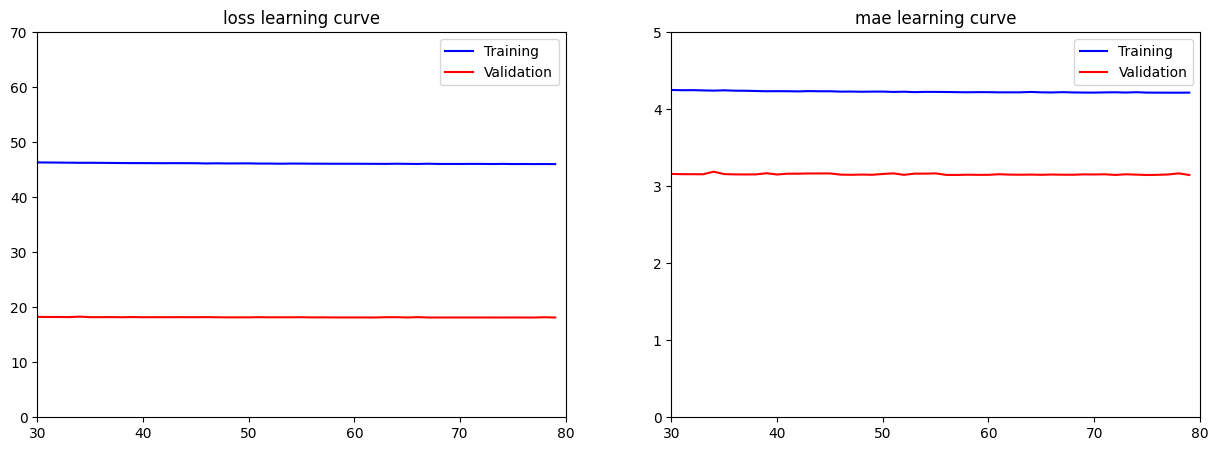

In [43]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch=30, metrics_max = [70, 5], val= True)

## CNN +LSTM

Since sequential models couldn't fully detect the patterns in the data compared to the 3-layer neural network, let's explore how a combination of CNN and LSTM models might perform.

In [22]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = [window_size-1, 1], kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None)))
model_cnn_lstm.add(LSTM(units =64, return_sequences = False, kernel_initializer=glorot_uniform(seed=None)))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.add(Lambda(lambda x: x*10))

model_cnn_lstm.compile(optimizer = SGD(learning_rate= 3e-5, momentum = .9), loss = "mse", metrics = ["mae"])
history = model_cnn_lstm.fit(feature_label_train, epochs = 40, validation_data=feature_label_test, verbose=1)


Epoch 1/40


c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 69.3112 - mae: 5.6700 - val_loss: 11.0336 - val_mae: 2.5117


c:\Users\solmaz\anaconda3\envs\TR\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 2/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.6431 - mae: 2.9959 - val_loss: 7.3083 - val_mae: 1.9944
Epoch 3/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.3897 - mae: 2.5049 - val_loss: 6.3089 - val_mae: 1.8754
Epoch 4/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.5167 - mae: 2.2986 - val_loss: 5.9256 - val_mae: 1.8322
Epoch 5/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.9425 - mae: 2.3438 - val_loss: 5.8371 - val_mae: 1.8171
Epoch 6/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.9818 - mae: 2.2360 - val_loss: 5.7256 - val_mae: 1.8020
Epoch 7/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.3355 - mae: 2.2045 - val_loss: 5.6495 - val_mae: 1.8010
Epoch 8/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9007 - mae: 2.1687 - val_loss: 5.5040 - val_mae: 1.7681
Epoch 9/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.0262 - mae: 2.1809 - val_loss: 5.3628 - val_mae: 1.7347
Epoch 10/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9837

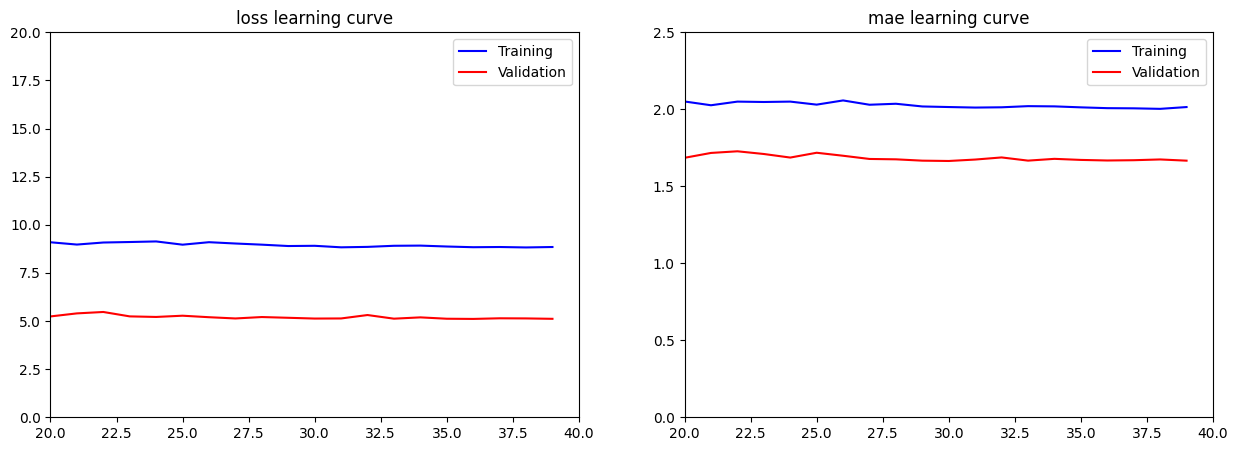

In [23]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch=20, metrics_max = [20, 2.5], val= True)

It seems the CNN+LSTM model outperforms all previous models and could be a strong candidate for model inference. However, in the Inference notebook, we will discuss why we cannot confidently assume this model on this dataset will be a good candidate for inferring the next week's ROI, which is a 21-step forecast horizon (3 * 7 = 21).